In [27]:
import matplotlib.pyplot as plt
import os, sys

from astropy.io import fits
from astropy.table import Table

import numpy as np

import matplotlib.colors as colors
from astropy.visualization import imshow_norm, MinMaxInterval, LogStretch,PercentileInterval, ImageNormalize

import sep

sys.path.append('/home/kevin/repos/ReipurthBallyProject/src')
sys.path.append('/home/kevin/repos/miscstat')

import chan_info as ci
import mls

rootdir = '/home/kevin/Documents/ZCMa-2014-12-18/W-S-I+'
frameid = 'SUPA01499557'
# rootdir = '/home/kevin/Documents/ZCMa-2014-12-18/W-S-I+'
# frameid2 = 'SUPA01499583'

# rootdir = '/home/kevin/Documents/ZCMa-2014-12-18/W-S-I+'
# frameid = 'SUPA01499573'

# rootdir = '/home/kevin/Documents/register/W-S-I+'
# frameid = 'SUPA01446865'

In [28]:
def match_to_region(match_tbl, reg_path, fitted=False):
    reghdr =[ '# Region file format: DS9 version 4.1',
            'global color=green dashlist=8 3 width=1 font="helvetica 10 normal roman" select=1 highlite=1 dash=0 fixed=0 edit=1 move=1 delete=1 include=1 source=1',
        'physical']

    with open(reg_path, 'w') as reg:
        for hdr in reghdr:
            reg.write(hdr+'\n')
        for row in match_tbl:
            # source point

            title = '{' + row['objid'] + '}'
            x_s = row['x']; y_s=row['y']
            point = f'point({x_s}, {y_s}) # point=circle text={title} color=green'
            reg.write(point+'\n')

            # destination point
            if fitted:
                title = '{' + row['objid'] + '_hat}'
                x_d = row['x_hat']; y_d=row['y_hat']
            else:
                title = '{' + row['gaiaid'] + '}'
                x_d = row['x_obsdate']; y_d=row['y_obsdate']
            point = f'point({x_d}, {y_d}) # point=circle text={title} color=red'
            reg.write(point+'\n')

            #arrow
            line = f'line( {x_s}, {y_s}, {x_d}, {y_d}) # line=0 1 color=green'
            reg.write(line+'\n')

In [29]:
from astropy.io.votable import parse_single_table
def load_catalog(cat_path):
    # cat_path = os.path.join(self.dirs['xmatch_tables'], img_name+'.xml')
    try:
        catalog = parse_single_table(cat_path).to_table()

    except:
        catalog = None
    return  catalog

In [30]:
def calc_distance(cat, obj_xy, cat_xy):
    xdisp = cat[cat_xy[0]] - obj_xy[0]
    ydisp = cat[cat_xy[1]] - obj_xy[1]
    dist = np.sqrt(xdisp**2 + ydisp**2)
    return dist

def calc_error(cat, flux):
    resid = np.sqrt((cat['flux_hat'] - flux)**2)
    return resid

def find_best(obj_xy, cat, cat_xy, cat_label):
    """
    returns value from catalog for catalog entry closest
    to obj_xy.
    Argurments:
        obj_xy, tuple (obj_x, obj_y)
        cat: table of catalog entries
        cat_xy: tuple ('cat_x', 'cat_y') columns in cat for xy coords
            of catalog entry
        cat_label: which field of catalog entry to be returned
    """
    dist = calc_distance(cat, obj_xy, cat_xy)

    minresid = np.argmin(dist)

    best_cat = cat[minresid][cat_label]

    return best_cat

## Fetch object and gaia catalogs

In [31]:
gaia_cat = load_catalog(os.path.join(rootdir, 'gaiacat',frameid+'.xml'))
gaia_cat.add_index('gaiaid')
obj_cat = load_catalog(os.path.join(rootdir, 'objcat',frameid+'.xml'))
obj_cat.add_index('objid')

## region to match table

In [32]:
'# vector(1628.552,99.596869,17.899903,52.293345) vector=1\n'

regfile = os.path.join(rootdir,'handmatch', frameid+'.reg')
regions = []
with open(regfile) as reg:
    for line in reg.readlines():
        if not line.startswith('# vector('): continue

        reg_params_str = line.split('(')[-1 ].split(')')[0]
        param_vals = [float(v) for v in reg_params_str.split(',')]
        regions.append(param_vals)

reg_table = Table(names=['x','y','len','theta_deg'], rows=regions)

#find the endpoints of the vectors
reg_table['theta_rad']= np.radians(reg_table['theta_deg'])
reg_table['x_prime'] = reg_table['x']+reg_table['len']*np.cos(reg_table['theta_rad'])
reg_table['y_prime'] = reg_table['y']+reg_table['len']*np.sin(reg_table['theta_rad'])

#snap the vector start and endpoints to objects and gaia

reg_table['objid'] = [find_best((r['x'], r['y']), obj_cat, ('x','y'),'objid') for r in reg_table]
reg_table['gaiaid'] = [find_best((r['x_prime'], r['y_prime']), gaia_cat, ('x_gaia','y_gaia'),'gaiaid') for r in reg_table]

In [33]:
reg_table


x,y,len,theta_deg,theta_rad,x_prime,y_prime,objid,gaiaid
float64,float64,float64,float64,float64,float64,float64,str8,str9
178.27646,4010.339,90.705154,344.85902,6.0189253542009755,265.8328808861312,3986.6472688734157,obj-0871,gaia-2710
192.18248,3952.6548,90.689068,346.20051,6.042338771583554,280.2539352980305,3931.0232069843287,obj-0858,gaia-2653
95.355381,3917.6322,92.572217,346.81424,6.053050380801818,185.4869894454059,3896.5156538965502,obj-0853,gaia-2695
64.968153,3754.3653,89.190801,349.0145,6.091452162201749,152.5245718663024,3737.3690504628166,obj-0808,gaia-2647
535.37885,3841.5306,80.145566,347.97965,6.073390622437486,613.7671198039818,3824.839557294449,obj-0838,gaia-2640
523.45668,3810.8311,81.251362,348.36031,6.080034392768128,603.0371665376023,3794.4381140214314,obj-0827,gaia-2641
677.74361,4060.5902,84.564601,344.27069,6.008657058612717,759.1415367230989,4037.665338659738,obj-0878,gaia-2882
625.82065,3940.7819,82.861921,345.60386,6.03192526460153,706.0806994795623,3920.180385265679,obj-0857,gaia-2879
682.04561,3995.29,83.008517,344.0953,6.005595925637644,761.8764641239222,3972.542502898465,obj-0865,gaia-2867


In [34]:
# just need the two id colums
catmatch = reg_table[['objid', 'gaiaid']]

In [35]:
#write the .mtch file:
with open(os.path.join(rootdir,'handmatch', frameid+'.mtch'),'w') as mtch:
    mtch.write(f'# {frameid}\n')
    for cm in catmatch:
        objid=cm['objid']; gaiaid=cm['gaiaid']
        mtch.write(f'{objid[4:]} {gaiaid[5:]}\n')

In [36]:
# import pandas as pd
# catmatch_pd = pd.read_csv(os.path.join(rootdir,'handmatch', frameid+'.mtch'), sep='\s+', comment='#', names=['obj_num', 'gaia_num'])
# catmatch_pd['objid'] = [f'obj-{i:04d}' for i in catmatch_pd.obj_num]
# catmatch_pd['gaiaid'] = [f'gaia-{i:04d}' for i in catmatch_pd.gaia_num]
# catmatch = Table.from_pandas(catmatch_pd)

In [37]:
# catmatch_pd

In [38]:
from astropy.table import join
matched_cat = join(join(obj_cat, catmatch, keys='objid'), gaia_cat, keys='gaiaid')
matched_cat['matchid'] = [f'match-{i:04d}' for i in range(len(matched_cat))]
matched_cat.add_index('matchid')

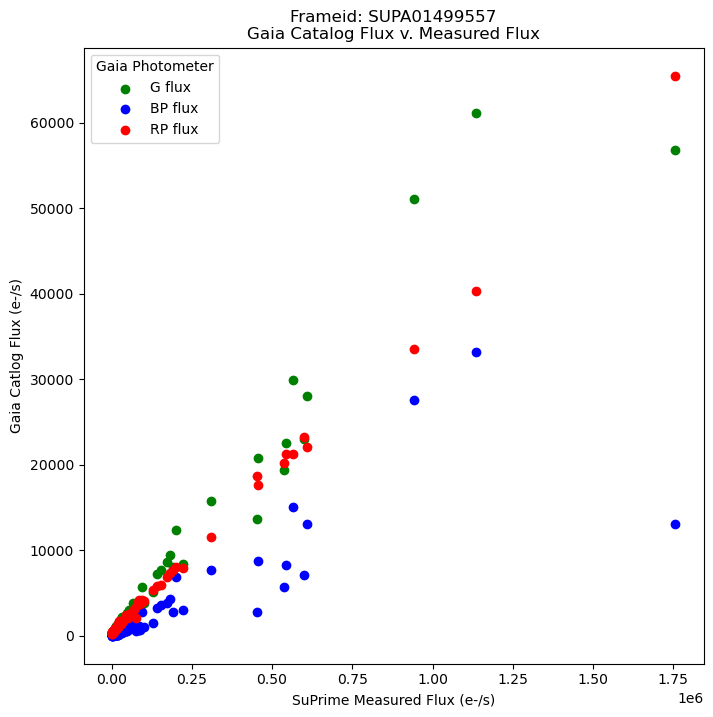

In [39]:
fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(matched_cat['flux'],matched_cat['phot_g_mean_flux'], color='green', label='G flux')
ax.scatter(matched_cat['flux'],matched_cat['phot_bp_mean_flux'], color='blue', label='BP flux')
ax.scatter(matched_cat['flux'],matched_cat['phot_rp_mean_flux'], color='red', label='RP flux')
ax.set_title(f'Frameid: {frameid}\nGaia Catalog Flux v. Measured Flux')
ax.set_ylabel('Gaia Catlog Flux (e-/s)')
ax.set_xlabel('SuPrime Measured Flux (e-/s)')
ax.legend(title='Gaia Photometer')

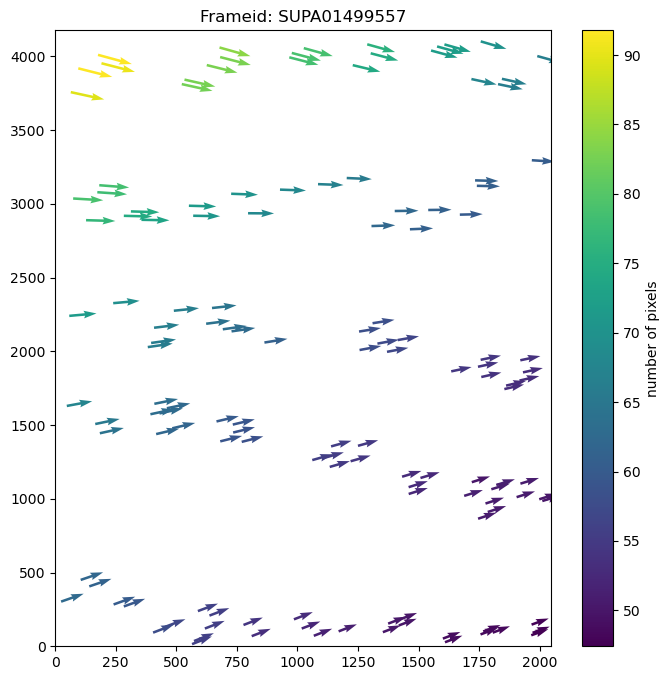

In [40]:
dx = np.array(matched_cat['x_obsdate']- matched_cat['x'])
dy = np.array(matched_cat['y_obsdate']- matched_cat['y'])
dist = np.sqrt(dx**2+dy**2)
fig, ax = plt.subplots(figsize=(8,8))
ax.set_xlim(0, 2048)
ax.set_ylim(0, 4177)
pcm =  ax.quiver(np.array(matched_cat['x']), np.array(matched_cat['y']), dx, dy, dist)
# for x,y,t in zip(matched_cat['x'], matched_cat['y'], matched_cat['objid']):
#     ax.text(x, y, t)

ax.set_title(f'Frameid: {frameid}')

fig.colorbar(pcm, label='number of pixels')

In [41]:
resids = np.sqrt((dx**2+dy**2))
top4=resids.argsort()[-4:] 
resids[top4]           

array([89.59844774, 90.54976409, 91.75733602, 91.78208563])

In [42]:
tbl = matched_cat.iloc[top4][['objid','gaiaid']]
m = resids.mean(); s=resids.std()
tbl['residual'] = resids[top4]
tbl['nsigma'] = (tbl['residual']-m)/s
tbl

objid,gaiaid,residual,nsigma
str8,str9,float64,float64
obj-0808,gaia-2647,89.59844773930001,2.627411694938699
obj-0858,gaia-2653,90.54976408967605,2.717496350162725
obj-0853,gaia-2695,91.75733601557663,2.831847060691318
obj-0871,gaia-2710,91.78208563156686,2.834190719162578


In [43]:
regpath = os.path.join(rootdir, 'matchregion',frameid+'.reg')
match_to_region(matched_cat, regpath)

In [44]:
frameid

'SUPA01499557'

In [20]:
zz = 'kevin'
zz[0:len(zz)-1]

'kevi'

In [ ]:
flux_df = pd.DataFrame({'matchid':matched_cat['matchid'], 'flux_obs':matched_cat['flux'], 'rp_flux': matched_cat['phot_rp_mean_flux'],
                        'npix':matched_cat['npix']})
flux_df.dropna(inplace=True)

flux_mod = mls.mls(flux_df, y='flux_obs',x=['rp_flux'])
print(flux_mod)

In [ ]:
flux_mod.plotfit()

In [ ]:
flux_mod.plotresid()

In [17]:
        # fig, ax = plt.subplots(figsize=(8,8))
        # ax.scatter(matched_cat['phot_rp_mean_flux'], matched_cat['npix'], color='red', label='npix')
        # ax.set_title('Pixels v. Gaia RP Flux')
        # ax.set_xlabel('Gaia Catlog RP Flux (e-/s)')
        # ax.set_ylabel('SuPrime Measured Flux (e-/s)')
        # ax.legend(title='Source Extractor')

In [25]:
import skimage as sk
def coord_map(matchtbl, fitted=False):

    # -1 below because x,y coords are DS9/Fits syle (i.e. 1-relative)
    if fitted:
        src  = np.array([matchtbl['x_hat'], matchtbl['y_hat']]).T -1
    else:
        src  = np.array([matchtbl['x'], matchtbl['y']]).T -1
    dest = np.array([matchtbl['x_gaia'], matchtbl['y_gaia']]).T -1

    return src, dest

def init_residuals(src, dest):
    n = src.shape[0]
    resid_sq = (dest-src)**2
    sum_sq = resid_sq.sum(axis=1)

    assert sum_sq.shape == (n,)

    return np.sqrt(sum_sq)

def rmse(resid):
    RMSE = np.sqrt((resid**2).mean())
    return RMSE

def hypotenuse(X):
    hyp = np.sqrt((X**2).sum(axis=1))
    return hyp

In [19]:
src, dest = coord_map(matched_cat)

In [ ]:
init_rmse = rmse(init_residuals(dest, src))
xform = sk.transform.estimate_transform('polynomial', src, dest, order=3)
resids = xform.residuals(  src, dest) 
final_rmse = rmse(resids)
resids2 = init_residuals(dest, xform(src))
rmse2 = rmse(resids2)
print(f'Inital RMSE: {init_rmse}, final RMSE: {final_rmse}, RMSE2: {rmse2}')

In [ ]:
np.allclose(resids, resids2)

## Initial Matching Based on Transform

In [ ]:
# estimate the transform on the hand-matched catalogs
src, dest = coord_map(matched_cat)
xform = sk.transform.estimate_transform('polynomial', src, dest, order=3)

# transform every member of the object catalog
obj_xy = np.array([obj_cat['x'], obj_cat['y']]).T
pos_hat = xform(obj_xy)

#make a table for find_best
pos_hat_tbl = Table({'x':pos_hat[:,0], 'y':pos_hat[:,1]})

obj_fit = obj_cat.copy()
obj_fit['gaiaid']=[find_best(o,gaia_cat, dist_only=True) for o in pos_hat_tbl]
obj_fit['x_hat'] = pos_hat[:,0]; obj_fit['y_hat'] = pos_hat[:,1]
obj_fit = join(obj_fit, gaia_cat, keys='gaiaid')

regpath = os.path.join(rootdir,'matchregion',frameid+'_xhat.reg')
match_to_region(obj_fit,regpath, fitted=True)

regpath = os.path.join(rootdir,'matchregion',frameid+'_xform.reg')
match_to_region(obj_fit,regpath)

## Same Transform, Different Frame


In [ ]:
# xform from previous frame


#catalogs
gaia_cat2 = load_catalog(os.path.join(rootdir, 'gaiacat',frameid2+'.xml'))
gaia_cat2.add_index('gaiaid')
obj_cat2 = load_catalog(os.path.join(rootdir, 'objcat',frameid2+'.xml'))
#obj_cat2.add_index('objid')

horizmargin = np.logical_and(obj_cat2['x'] >= 40, obj_cat2['x'] <= (2048-40))
vertmargin = np.logical_and(obj_cat2['y'] >= 40, obj_cat2['y'] <= (4177-40))
marginok = np.logical_and(horizmargin, vertmargin)

sizeok = np.logical_and(obj_cat2['npix']>=50, obj_cat2['npix'] <= 2500)
validobs = np.logical_and(marginok, sizeok)
obj_cat2 = obj_cat2[validobs]

# we know these objects to be bogus for frameid frameid2 = 'SUPA01499583'
# badrows = obj_cat2.loc_indices[['obj-0196','obj-0691', 'obj-0203']]
# obj_cat2.remove_rows(badrows)

# transform every member of the object catalog
obj_xy = np.array([obj_cat2['x'], obj_cat2['y']]).T
pos_hat = xform(obj_xy)

#make a table for find_best
pos_hat_tbl = Table({'x':pos_hat[:,0], 'y':pos_hat[:,1]})

obj_fit = obj_cat2.copy()
obj_fit['gaiaid']=[find_best(o,gaia_cat2, dist_only=True) for o in pos_hat_tbl]
obj_fit['x_hat'] = pos_hat[:,0]; obj_fit['y_hat'] = pos_hat[:,1]
obj_fit = join(obj_fit, gaia_cat2, keys='gaiaid')

regpath = os.path.join(rootdir,'matchregion',frameid2+'_xhat.reg')
match_to_region(obj_fit,regpath, fitted=True)

regpath = os.path.join(rootdir,'matchregion',frameid2+'_xform.reg')
match_to_region(obj_fit,regpath)

### Recalculate RMSE given new pairing

In [ ]:
from sklearn.neighbors import LocalOutlierFactor


In [ ]:
src, dest = coord_map(obj_fit)
init_rmse = rmse(init_residuals(dest, src))
xform = sk.transform.estimate_transform('polynomial', src, dest, order=3)
resids = xform.residuals(  src, dest)
out_rmse = rmse(resids)

# ditch the outliers
lof = LocalOutlierFactor(n_neighbors=50)
X = [[x] for x in resids]
outliers = lof.fit_predict(X)
inliers = outliers == 1

#recalc transform using just the inliers
xform = sk.transform.estimate_transform('polynomial', src[inliers], dest[inliers])
in_rmse = rmse(xform.residuals(src[inliers], dest[inliers]))

print(f'Inital RMSE: {init_rmse}, RMSE with outliers: {out_rmse}, RMSE outliers removed: {in_rmse}')

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))
ax.set_xlim(0, 2048)
ax.set_ylim(0, 4177)
pcm = ax.scatter(src[:,0], src[:,1],c=xform.residuals(src, dest))
fig.colorbar(pcm)

In [ ]:
resids.mean(), resids.std()

In [ ]:
obj_fit[obj_fit['objid']=='obj-0691']

In [ ]:
resids2.max(), resids2.argmax()

In [ ]:
obj_fit[212]

In [29]:
from sklearn.neighbors import LocalOutlierFactor
lof = LocalOutlierFactor()
X = [[x] for x in resids2]
outliers = lof.fit_predict(X)

In [ ]:
resids[outliers==-1]

The above looks to work really well. It suggests the following algorithm:
1. open up coordinate pairs for the detector (perhaps previously saved)
2. calculate the transform
3. apply the transform to the objects in the current frame
4. find the closest gaia to the transform
5. calculate new coordinate pairs
6. calculate inverse transform
7. warp image


## Initial Least Squares Matching

### Flux model from the hand-matched pairs

In [ ]:
flux_df = pd.DataFrame({'matchid':matched_cat['matchid'], 'flux_obs':matched_cat['flux'], 'rp_flux': matched_cat['phot_rp_mean_flux'],
                        'npix':matched_cat['npix']})
flux_df.dropna(inplace=True)

flux_mod = mls.mls(flux_df, y='flux_obs',x=['rp_flux'])
print(flux_mod)


In [22]:
sobj_cat= obj_cat[obj_cat['flux'] <= 250000].copy()

sgaia_cat = gaia_cat[~gaia_cat['phot_rp_mean_flux'].mask].copy()

#use coefs from fitted model to predict flux
sgaia_cat['flux_hat'] = flux_mod.beta_hat[0][0]+ flux_mod.beta_hat[1][0]*sgaia_cat['phot_rp_mean_flux']
sgaia_cat['unmatched']=True

In [23]:
def calc_distance(cat, x, y):
    xdisp = cat['x_gaia'] - x
    ydisp = cat['y_gaia'] - y
    dist = np.sqrt(xdisp**2 + ydisp**2)
    return dist

def calc_error(cat, flux):
    resid = np.sqrt((cat['flux_hat'] - flux)**2)
    return resid

def find_best(obj, cat, dist_only=False):
    dist = calc_distance(cat, obj['x'], obj['y'])
    if dist_only:
        minresid = np.argmin(dist)
    else:
        valid = np.logical_and(dist >= 10, dist <= 100)
        #valid = np.logical_and(valid, cat['unmatched'])
        resid = calc_error(cat, obj['flux'])
        resid = np.where(valid, resid, np.nan)
        minresid = np.nanargmin(resid)
    #cat[minresid]['unmatched']= False
    best_cat = cat[minresid]['gaiaid']
    return best_cat

In [ ]:
sobj_cat['gaiaid'] = [find_best(o,sgaia_cat) for o in sobj_cat]
sobj_cat = join(sobj_cat, gaia_cat, keys='gaiaid')
regpath = os.path.join(rootdir,'matchregion',frameid+'_init.reg')
match_to_region(sobj_cat, regpath)

### Flux model after AutoMatch

In [ ]:
flux_df = pd.DataFrame({ 'flux_obs':sobj_cat['flux'], 'rp_flux': sobj_cat['phot_rp_mean_flux'],
                        'npix':sobj_cat['npix']})
flux_df.dropna(inplace=True)

flux_mod = mls.mls(flux_df, y='flux_obs',x=['rp_flux'])
print(flux_mod)

### Iterating on the AutoMatch

**N.B.: this didn't work!** so don't do it!!

In [26]:
# sobj_cat= obj_cat[obj_cat['flux'] <= 250000].copy()
# sgaia_cat = gaia_cat[~gaia_cat['phot_rp_mean_flux'].mask].copy()
# sgaia_cat['flux_hat'] = flux_mod.beta_hat[0][0]+ flux_mod.beta_hat[1][0]*sgaia_cat['phot_rp_mean_flux']
# sgaia_cat['unmatched'] = True
# sobj_cat['gaiaid'] = [find_best(o,sgaia_cat) for o in sobj_cat]
# sobj_cat = join(sobj_cat, gaia_cat, keys='gaiaid')
# regpath = os.path.join(rootdir,'matchregion',frameid+'_iter0.reg')
# match_to_region(sobj_cat, regpath)

In [ ]:
frameid

## Nearest Neighbor Regression

In [28]:
from sklearn import neighbors

In [ ]:
src = np.array([sobj_cat['x'], sobj_cat['y']]).T
dest = np.array([sobj_cat['x_gaia'], sobj_cat['y_gaia']]).T
obj_xy = np.array([obj_cat['x'], obj_cat['y']]).T

# n_neighbors = 20
# knn = neighbors.KNeighborsRegressor(n_neighbors, weights='distance')
radius = 200
knn = neighbors.RadiusNeighborsRegressor(radius, weights='distance')

pos_hat = knn.fit(src, dest).predict(obj_xy)

#make a table for find_best
pos_hat_tbl = Table({'x':pos_hat[:,0], 'y':pos_hat[:,1]})

obj_fit = obj_cat.copy()
obj_fit['gaiaid']=[find_best(o,gaia_cat, dist_only=True) for o in pos_hat_tbl]
obj_fit['x_hat'] = pos_hat[:,0]; obj_fit['y_hat'] = pos_hat[:,1]
obj_fit = join(obj_fit, gaia_cat, keys='gaiaid')

regpath = os.path.join(rootdir,'matchregion',frameid+'_hat.reg')
match_to_region(obj_fit,regpath, fitted=True)

regpath = os.path.join(rootdir,'matchregion',frameid+'_knn.reg')
match_to_region(obj_fit,regpath)

In [ ]:
frameid

In [ ]:
len(obj_cat)

In [ ]:
obj_xy[:10]

In [ ]:
len(sobj_cat)

In [ ]:
src.data.shape

In [ ]:
sobj_cat[['x','y', 'x_gaia','y_gaia']]